<a href="https://colab.research.google.com/github/daferocu/Topicos-Avanzados/blob/main/datalab/Talleres%202/E7%20-%20RNN%2C%20LSTM%2C%20GRU/E6_RNN_LSTM_GRU_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Profesor:** Sergio Alberto Mora Pardo

**Integrantes:**

*   Daniel Rodríguez
*   Diana Ibáñez
*   Oscar Correcha
*   Erika Cárdenas
*   Paola Castro

# Exercise 6

## Predict rating using LSTM


In [2]:
!pip install tensorflow
!pip install livelossplot

In [3]:
# Instalar librerías requeridas
import pandas as pd
import numpy as np
import random
import math

import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords') # Descargar la lista de palabras comunes (stopwords) en varios idiomas que se consideran poco informativas en el análisis de texto.
nltk.download('punkt') # Descarga los modelos y datos necesarios para la tokenización del texto.

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from livelossplot import PlotLossesKeras


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# Leer el dataset
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)

In [5]:
# Definir x (plots) y y
plots = dataTraining['plot']
# El rating de cada película se convierte en 1 si es mayor o igual al promedio del rating en el conjunto de datos, y en 0 si es menor. Esto convierte el problema en una tarea de clasificación binaria.
#y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

y = (dataTraining['rating'] >= math.floor (dataTraining['rating'].mean())).astype(int) # 1 es mayor o igual a la media redondeada hacia abajo.

In [6]:
plots

,plot
3107,most is the story of a single father who takes...
900,a serial killer decides to teach the secrets o...
6724,"in sweden , a female blackmailer with a disfi..."
4704,"in a friday afternoon in new york , the presi..."
2582,"in los angeles , the editor of a publishing h..."
...,...
8417,""" our marriage , their wedding . "" it ' s l..."
1592,"the wandering barbarian , conan , alongside ..."
1723,"like a tale spun by scheherazade , kismet fol..."
7605,"mrs . brisby , a widowed mouse , lives in a..."


In [7]:
y

,rating
3107,1
900,0
6724,1
4704,1
2582,1
...,...
8417,0
1592,0
1723,1
7605,1


# Exercise 6.1

- Remove stopwords
- Lowercase
- split the text in words
- pad_sequences

In [8]:
# Función para quitar stopwords
def quitar_stopwords(texto):
    texto_tokenizado = word_tokenize(texto)  # Tokenizar el texto
    stop_words = set(stopwords.words('english'))  # Cargar stopwords en inglés
    return [palabra for palabra in texto_tokenizado if palabra not in stop_words]

# Función para procesar el texto
def procesamiento(texto):
    texto = texto.lower()  # Convertir texto a minúsculas
    texto = re.sub(r'[^a-zA-Z0-9]', ' ', texto)  # Remover caracteres no deseados
    texto_sinStopwords = quitar_stopwords(texto)  # Remover stop words
    texto_limpio = ' '.join(texto_sinStopwords)  # Unir los tokens nuevamente en texto
    return texto_limpio


In [9]:
# Aplicar preprocesamiento de texto definido a la data de entrenamiento
plots_procesados = plots.apply(procesamiento)

plots_procesados

,plot
3107,story single father takes eight year old son w...
900,serial killer decides teach secrets satisfying...
6724,sweden female blackmailer disfiguring facial s...
4704,friday afternoon new york president tredway co...
2582,los angeles editor publishing house carol hunn...
...,...
8417,marriage wedding lesson number one newly engag...
1592,wandering barbarian conan alongside goofy rogu...
1723,like tale spun scheherazade kismet follows rem...
7605,mrs brisby widowed mouse lives cinder block ch...


In [10]:
# Convertir cada palabra de plots en números enteros
texto_tokenizado = Tokenizer() # Tokenizar el texto
texto_tokenizado.fit_on_texts(plots_procesados)
plots_numeros = texto_tokenizado.texts_to_sequences(plots_procesados)

# Se determina la longitud máxima de todas las palabras convertidas en números
max_num_len = max([len(x) for x in plots_procesados])
# Aplicar padding para que todas las palabras convertidas a número tengan longitud de 100, agregando ceros al final
plots_padded = pad_sequences(plots_numeros, maxlen=max_num_len, padding='post')

plots_padded, max_num_len

(array([[   37,   531,    11, ...,     0,     0,     0],
        [  913,   190,    50, ...,     0,     0,     0],
        [ 8365,   544,  7247, ...,     0,     0,     0],
        ...,
        [   51,   713, 23307, ...,     0,     0,     0],
        [  370,  9984,  1491, ...,     0,     0,     0],
        [38513,  3095,   383, ...,     0,     0,     0]], dtype=int32),
 5530)

In [11]:
# Separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(plots_padded, y, test_size=0.30, random_state=42)

# Exercise 6.2

Create a SimpleRNN neural network to predict the rating of a movie

Calculate the testing set accuracy

In [12]:
# Cambiamos la forma de los datos de entrada para que se ajusten al formato esperado por la RNN (número de muestras, longitud de secuencia, características).
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Se realizan diferentes pruebas con una capa (50 neuronas) y dos capas (una de 100 y otra de 50 neuronas), con y sin Dropout, con y sin learning rate de 0.1, con 100, 50 y 30 épocas.

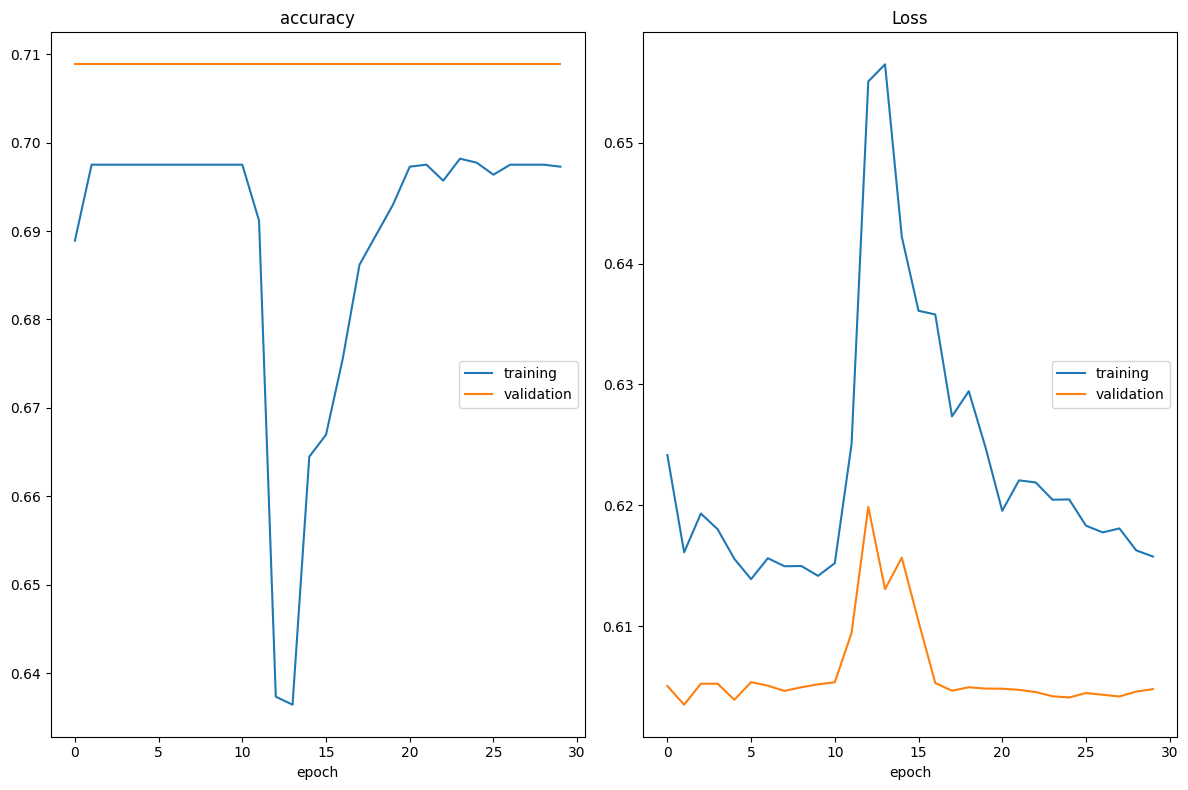

accuracy
	training         	 (min:    0.636, max:    0.698, cur:    0.697)
	validation       	 (min:    0.709, max:    0.709, cur:    0.709)
Loss
	training         	 (min:    0.614, max:    0.656, cur:    0.616)
	validation       	 (min:    0.603, max:    0.620, cur:    0.605)
139/139 ━━━━━━━━━━━━━━━━━━━━ 67s 480ms/step - accuracy: 0.6972 - loss: 0.6144 - val_accuracy: 0.7089 - val_loss: 0.6048
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.7021 - loss: 0.6097


In [14]:
random.seed(38)
np.random.seed(38)
tf.random.set_seed(38)

# Definir el modelo de RNN
model = Sequential()
model.add(SimpleRNN(50, input_shape=(5530, 1), return_sequences=False)) # Función de activación en la capa de entrada por defecto tanh / return_sequences en False para devolver la solo la última secuencia (por ser la única capa, también aplica a la última capa)
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_reshaped, y_train, epochs=30, validation_split=0.2, callbacks=[PlotLossesKeras()])

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)

# Exercise 6.3

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

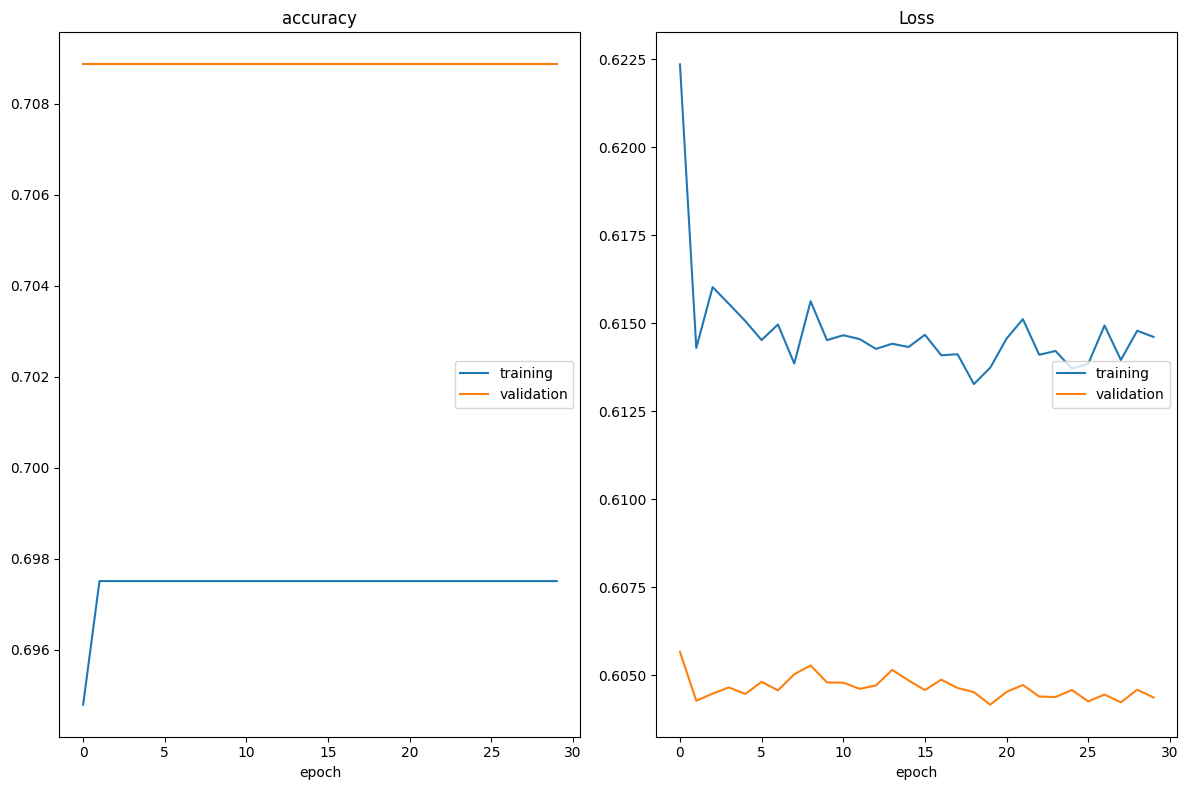

accuracy
	training         	 (min:    0.695, max:    0.698, cur:    0.698)
	validation       	 (min:    0.709, max:    0.709, cur:    0.709)
Loss
	training         	 (min:    0.613, max:    0.622, cur:    0.615)
	validation       	 (min:    0.604, max:    0.606, cur:    0.604)
139/139 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.6973 - loss: 0.6150 - val_accuracy: 0.7089 - val_loss: 0.6044
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 590ms/step - accuracy: 0.7021 - loss: 0.6096


In [13]:
random.seed(38)
np.random.seed(38)
tf.random.set_seed(38)

# Definir el modelo de LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_reshaped, y_train, epochs=30, validation_split=0.2, callbacks=[PlotLossesKeras()])

# Evaluar el modelo en los datos de prueba
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)

# Exercise 6.4

Create a GRU neural network to predict the rating of a movie

Calculate the testing set accuracy

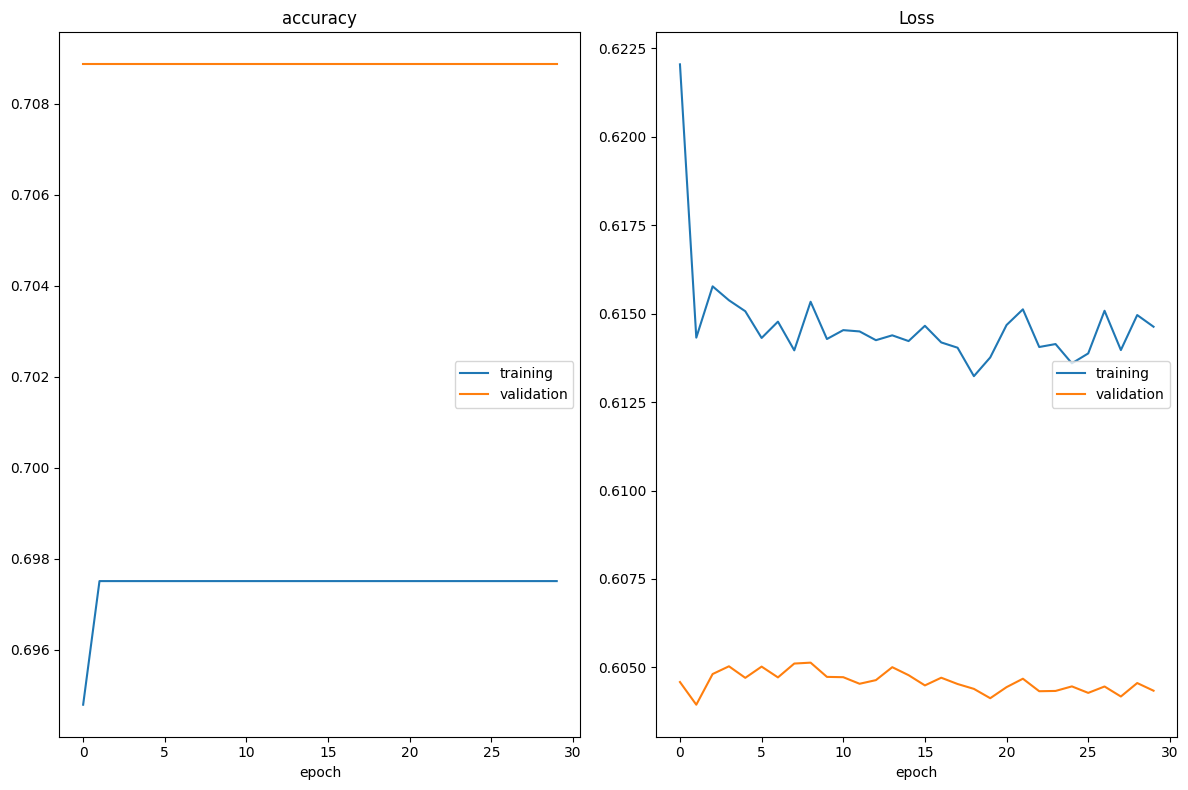

accuracy
	training         	 (min:    0.695, max:    0.698, cur:    0.698)
	validation       	 (min:    0.709, max:    0.709, cur:    0.709)
Loss
	training         	 (min:    0.613, max:    0.622, cur:    0.615)
	validation       	 (min:    0.604, max:    0.605, cur:    0.604)
139/139 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.6973 - loss: 0.6151 - val_accuracy: 0.7089 - val_loss: 0.6043
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 563ms/step - accuracy: 0.7021 - loss: 0.6096


In [15]:
random.seed(38)
np.random.seed(38)
tf.random.set_seed(38)

# Definir el modelo de GRU
model = Sequential()
model.add(GRU(50, input_shape=(X_train.shape[1], 1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_reshaped, y_train, epochs=30, validation_split=0.2, callbacks=[PlotLossesKeras()])

# Evaluar el modelo en los datos de prueba
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)